# Trabalho A2 - Análise de Séries Temporais

## Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, MeanAbsoluteScaledError,
)
from scipy.stats import boxcox
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import itertools
from sklearn.model_selection import TimeSeriesSplit
from scipy.special import inv_boxcox

## Dados

In [3]:
prison = pd.read_csv("data_updated.csv")

In [4]:
prison

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458


In [5]:
# Converte a coluna "week" para datetime
prison["week"] = pd.to_datetime(prison["week"])

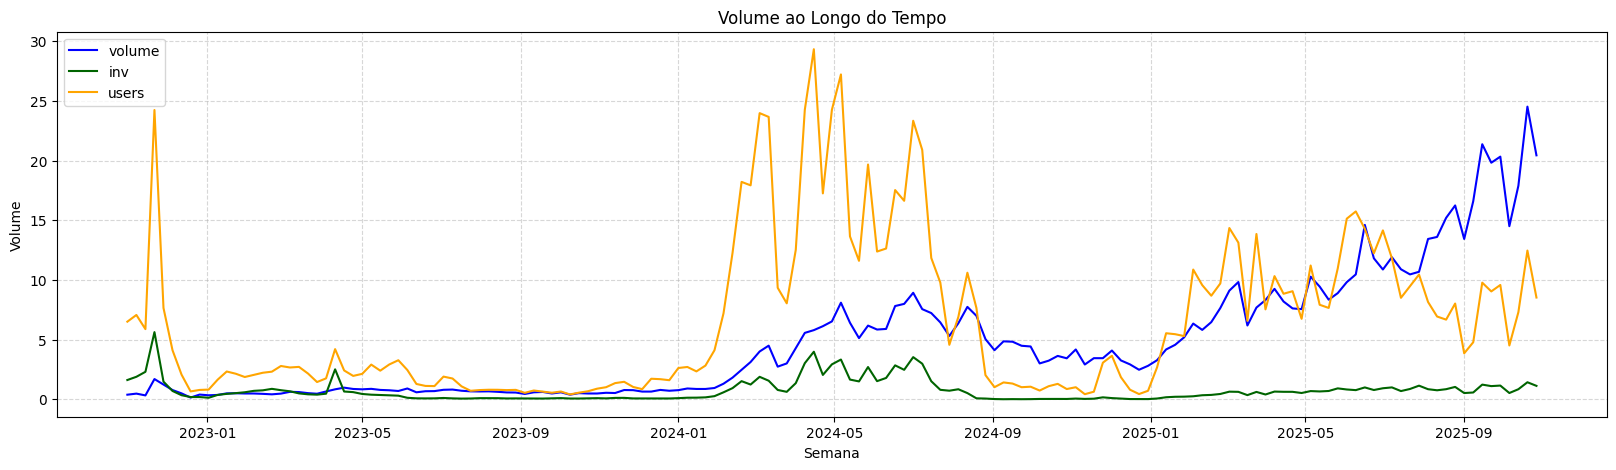

In [26]:
# Criar o gráfico
plt.figure(figsize=(20, 5))
plt.plot(prison["week"], prison["volume"], linestyle="-", marker="", color="blue", label="volume")
plt.plot(prison["week"], prison["inv"], linestyle="-", marker="", color="darkgreen", label="inv")
plt.plot(prison["week"], prison["users"], linestyle="-", marker="", color="orange", label="users")

# Labels e título
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.title("Volume ao Longo do Tempo")
plt.legend(loc="upper left")

# Estilo minimalista
plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
plt.show()

Plots de cada variável separada

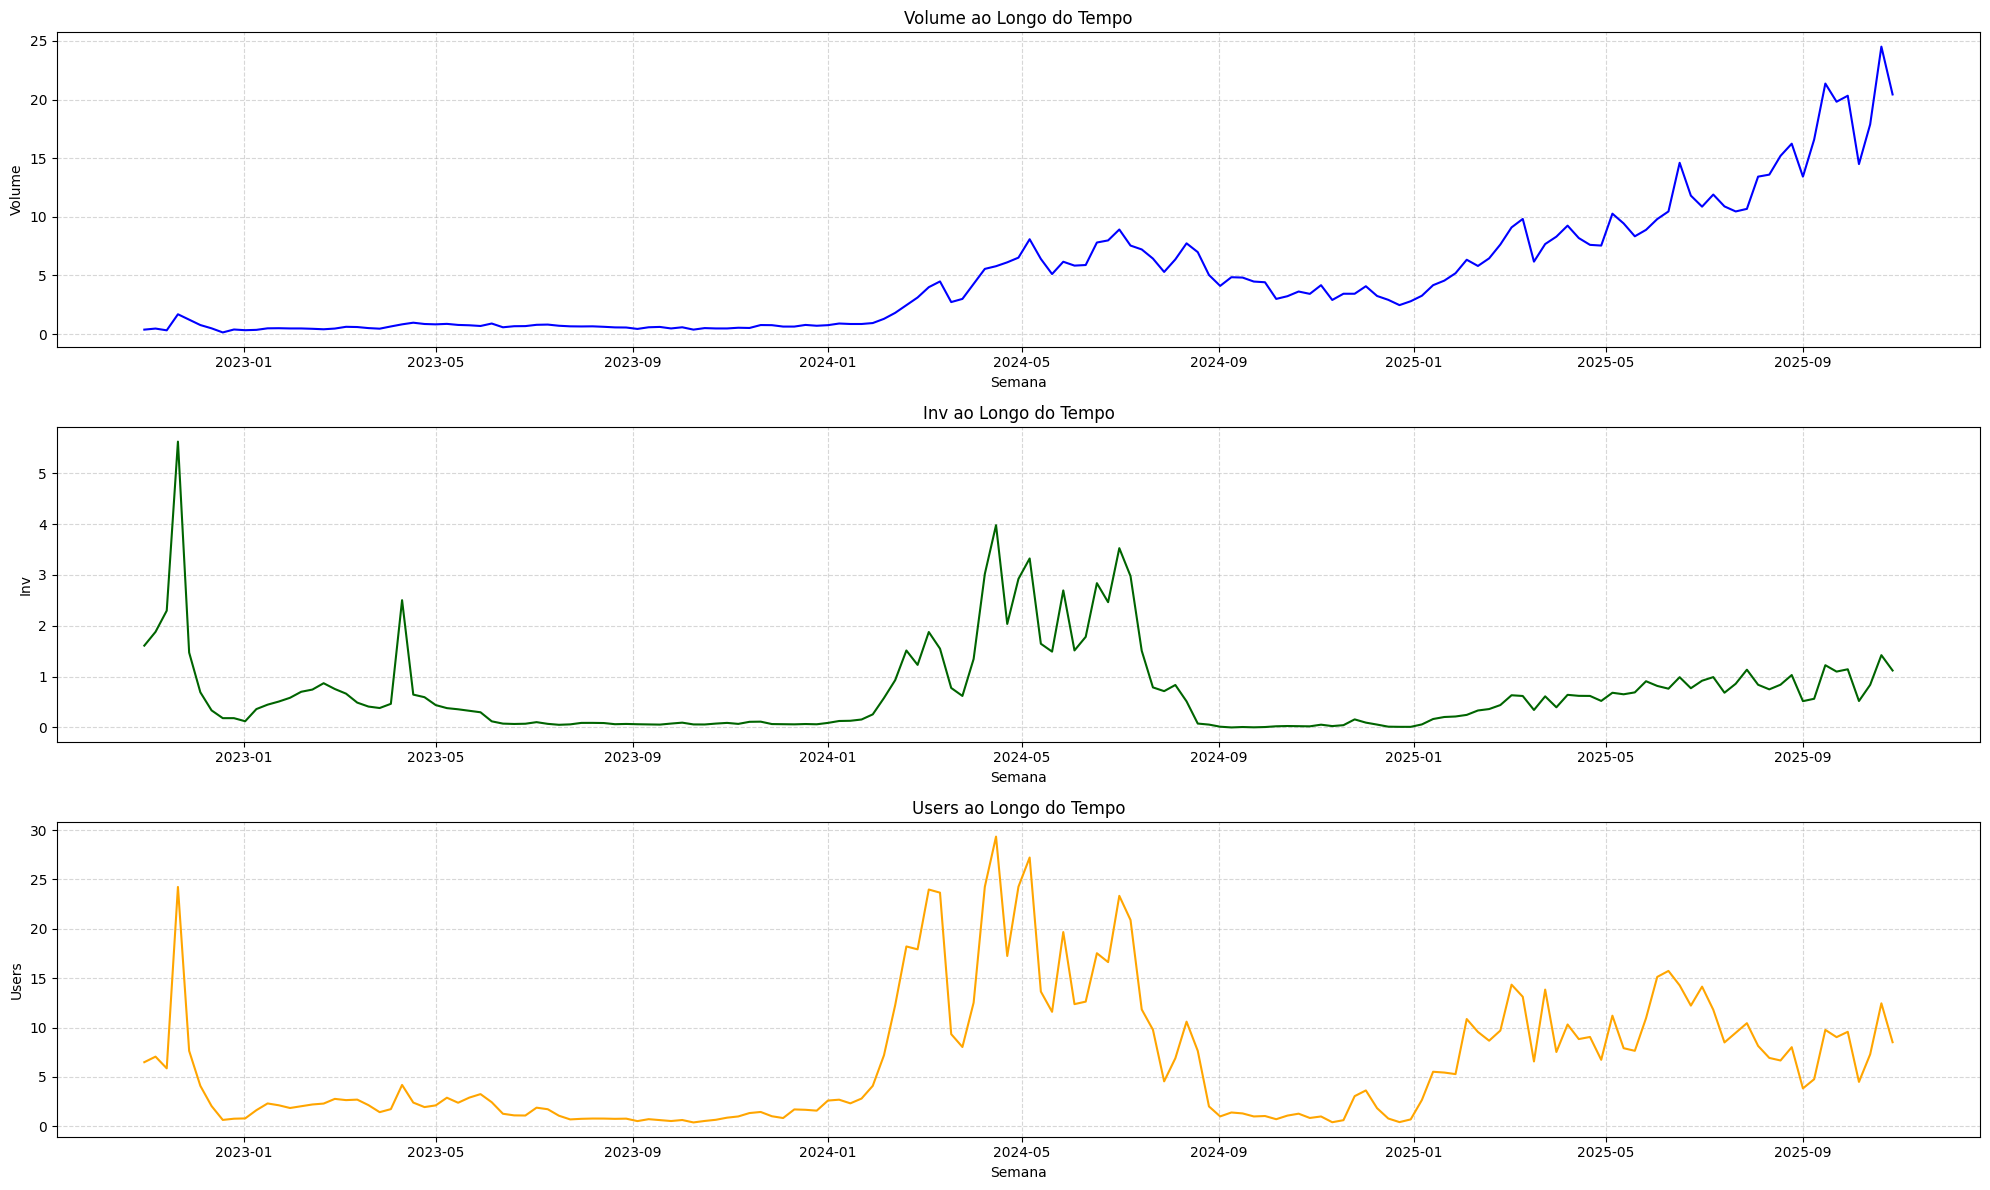

In [72]:
colors = ["blue", "darkgreen", "orange"]
columns = prison.columns

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i in range(3):
    ax = axes[i]
    column = columns[i + 1]

    ax.plot(prison["week"], prison[column], linestyle="-", marker="", color=colors[i])

    # Labels e título
    ax.set_xlabel("Semana")
    ax.set_ylabel(column.title())
    ax.set_title(f"{column.title()} ao Longo do Tempo")

    # Estilo minimalista
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

## Baselines

**Mean**: média simples de todos os dados históricos.

**Naive**: usa simplesmente o último valor observado como previsão.

**Snaive**: usa o último valor observado da mesma estação.

**Drift**: tendência linear baseada no primeiro e no último valor da série.


In [7]:
# série semanal com frequência explícita
y = prison.sort_values("week").set_index("week")["volume"]
y = y.asfreq(pd.infer_freq(y.index) or "W")

h = 52  # horizonte
y_tr, y_te = y.iloc[:-h], y.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

In [8]:
def fit_pred(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr)
    return f.predict(fh)

preds = {
    "mean":  fit_pred("mean", sp=1),
    "naive": fit_pred("last", sp=1),
    "snaive": fit_pred("last", sp=52),   # sazonal 
    "drift": fit_pred("drift", sp=1),
}

mase_metric = MeanAbsoluteScaledError(sp=52)  

rows = []
for name, yhat in preds.items():
    rows.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te, yhat),
        "RMSE": mean_squared_error(y_te, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
        "MASE": mase_metric(y_te, yhat, y_train=y_tr),
    })

metrics = pd.DataFrame(rows).sort_values("RMSE").round(3)
metrics

,model,MAE,RMSE,MAPE_%,MASE
3,drift,2.894,3.671,39.182,0.836
2,snaive,4.083,4.621,59.579,1.180
1,naive,3.763,4.857,44.402,1.088
0,mean,5.485,6.748,61.472,1.585


**MAE**: erro absoluto médio.

**RMSE**: raiz do erro quadrático médio.

**MAPE**: erro percentual absoluto médio.

**MASE**: erro absoluto escalado médio.


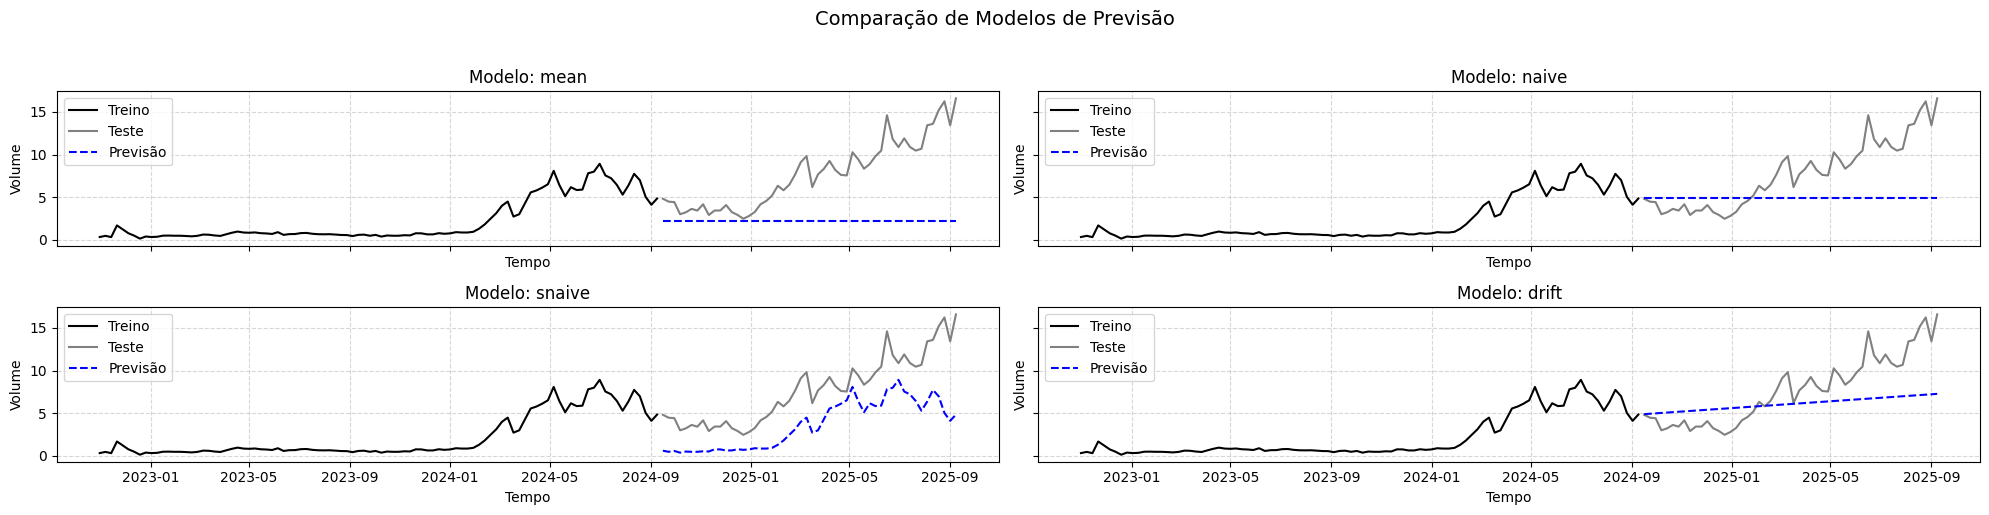

In [9]:
# Cria um grid 2x2 de subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()

# Loop pelos modelos e eixos
for i, (name, yhat) in enumerate(preds.items()):
    ax = axes[i]
    # Série observada (treino + teste)
    ax.plot(y_tr.index, y_tr, color="black", label="Treino")
    ax.plot(y_te.index, y_te, color="gray", label="Teste")
    # Previsão
    ax.plot(y_te.index, yhat, color="blue", linestyle="--", label="Previsão")
    
    ax.set_title(f"Modelo: {name}")
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Volume")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Comparação de Modelos de Previsão", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## Transformação de Variáveis

A série apresentou heterocedasticidade, portanto aplicou-se a transformação Box-Cox para estabilizar a variância.

In [10]:
prison = prison.set_index("week")
y = prison["volume"]

y_bc, lmbda = boxcox(y)

print(f"O valor de lambda (λ) é: {lmbda:.4f}")

O valor de lambda (λ) é: 0.0496


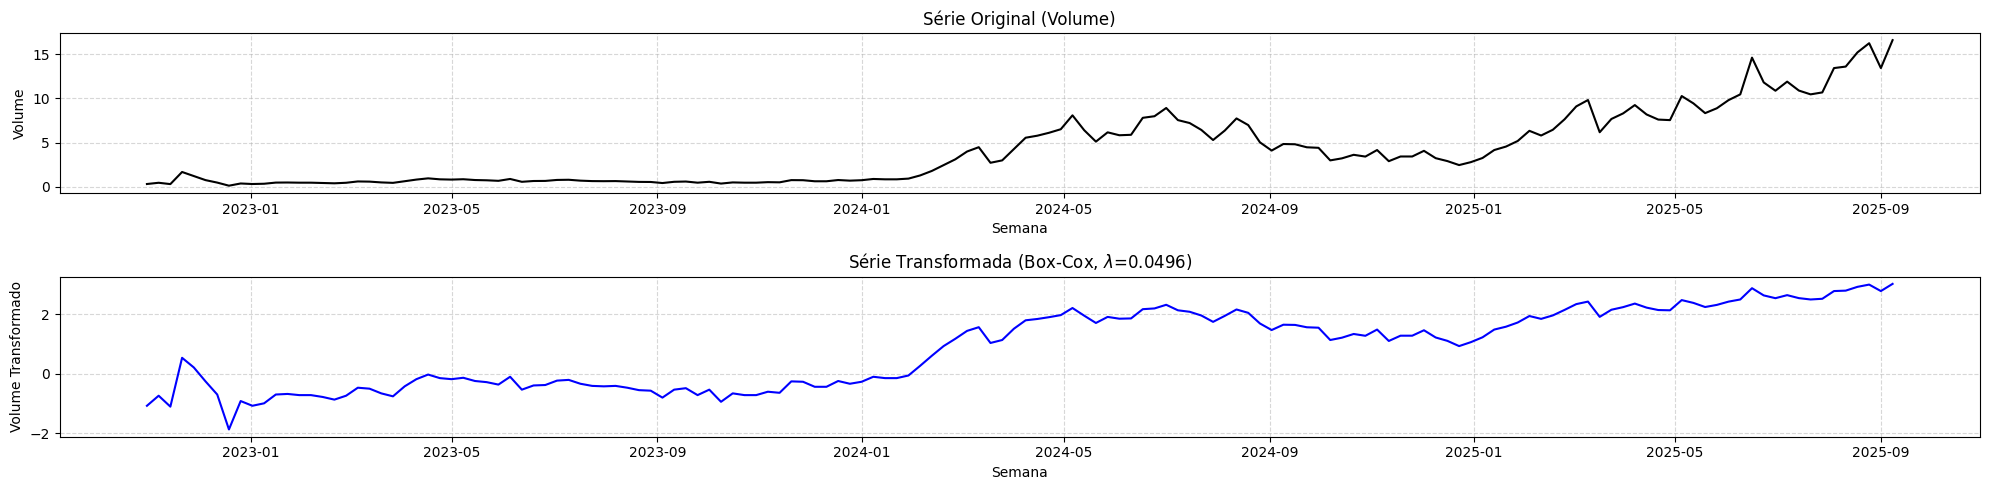

In [11]:
# Armazena a série transformada no DataFrame para futuras modelagens
prison["volume_bc"] = y_bc

# Criar o gráfico
fig, axes = plt.subplots(2, 1, figsize=(20, 5))

# Série Original
axes[0].plot(prison["volume"], linestyle="-", color="black")
axes[0].set_title("Série Original (Volume)")
axes[0].set_ylabel("Volume")
axes[0].set_xlabel("Semana")
axes[0].grid(True, linestyle="--", alpha=0.5)

# Série Transformada
axes[1].plot(prison["volume_bc"], linestyle="-", color="blue")
axes[1].set_title(f"Série Transformada (Box-Cox, $\\lambda$={lmbda:.4f})")
axes[1].set_ylabel("Volume Transformado")
axes[1].set_xlabel("Semana")
axes[1].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
y_bc = prison["volume_bc"]
y_bc = y_bc.asfreq(pd.infer_freq(y_bc.index) or "W")

h = 52
y_tr_bc, y_te_bc = y_bc.iloc[:-h], y_bc.iloc[-h:]
fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)

def fit_pred_bc(strategy, sp=1):
    f = NaiveForecaster(strategy=strategy, sp=sp)
    f.fit(y_tr_bc)
    return f.predict(fh)

preds_bc = {
    "mean":  fit_pred_bc("mean", sp=1),
    "naive": fit_pred_bc("last", sp=1),
    "snaive": fit_pred_bc("last", sp=52),
    "drift": fit_pred_bc("drift", sp=1),
}

mase_metric = MeanAbsoluteScaledError(sp=52)

rows_bc = []
for name, yhat in preds_bc.items():
    rows_bc.append({
        "model": name,
        "MAE":  mean_absolute_error(y_te_bc, yhat),
        "RMSE": mean_squared_error(y_te_bc, yhat, square_root=True),
        "MAPE_%": mean_absolute_percentage_error(y_te_bc, yhat) * 100,
        "MASE": mase_metric(y_te_bc, yhat, y_train=y_tr_bc),
    })

metrics_bc = pd.DataFrame(rows_bc).sort_values("RMSE").round(3)
metrics_bc


,model,MAE,RMSE,MAPE_%,MASE
3,drift,0.391,0.472,26.115,0.236
1,naive,0.603,0.700,29.641,0.364
2,snaive,1.130,1.283,70.674,0.681
0,mean,1.784,1.883,87.965,1.076


## Decomposição STL


Realiza-se a decomposição STL para separar o volume em tendência, sazonalidade e resíduo a fim de inspecionar a estrutura da série e identificar padrões persistentes ao longo do tempo.

In [13]:
series_orig = prison["volume"].asfreq(pd.infer_freq(prison.index) or "W")
stl_orig = STL(series_orig, period=52, robust=True).fit()

In [14]:
series_bc = prison["volume_bc"].asfreq(pd.infer_freq(prison.index) or "W")
stl_bc = STL(series_bc, period=52, robust=True).fit()

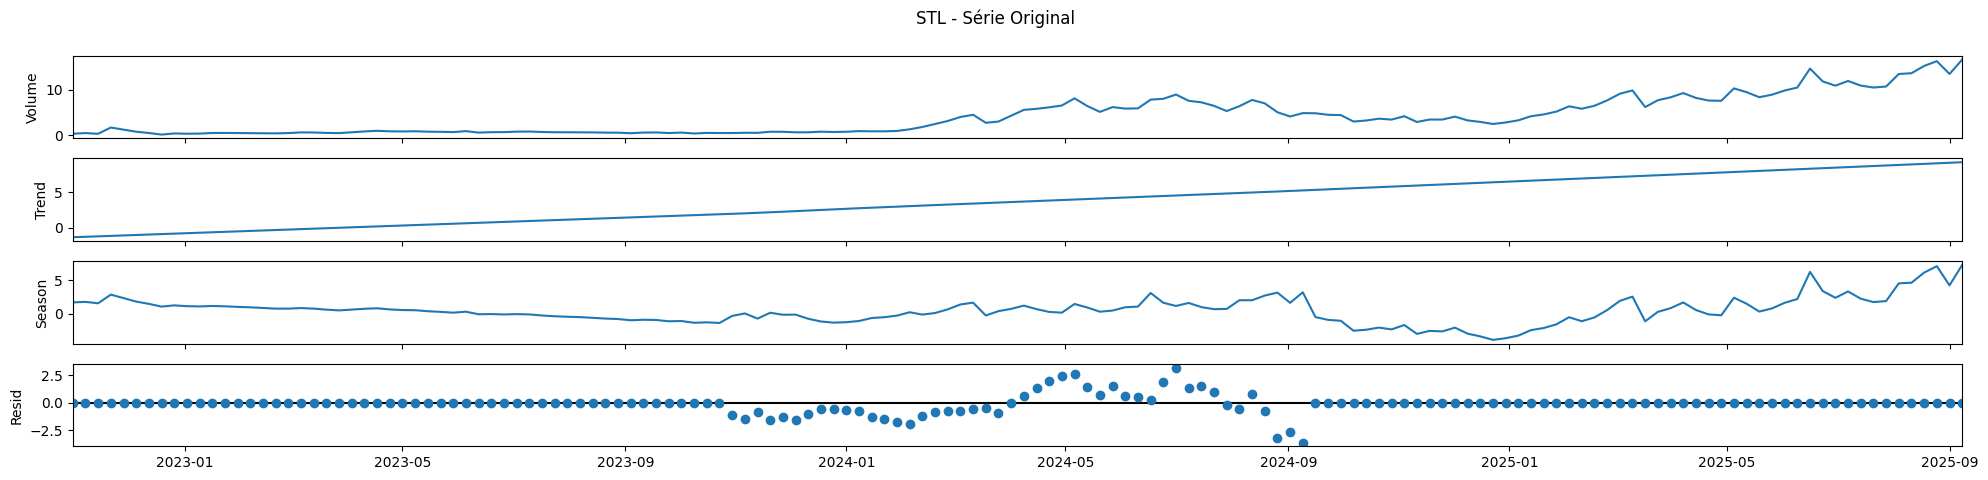

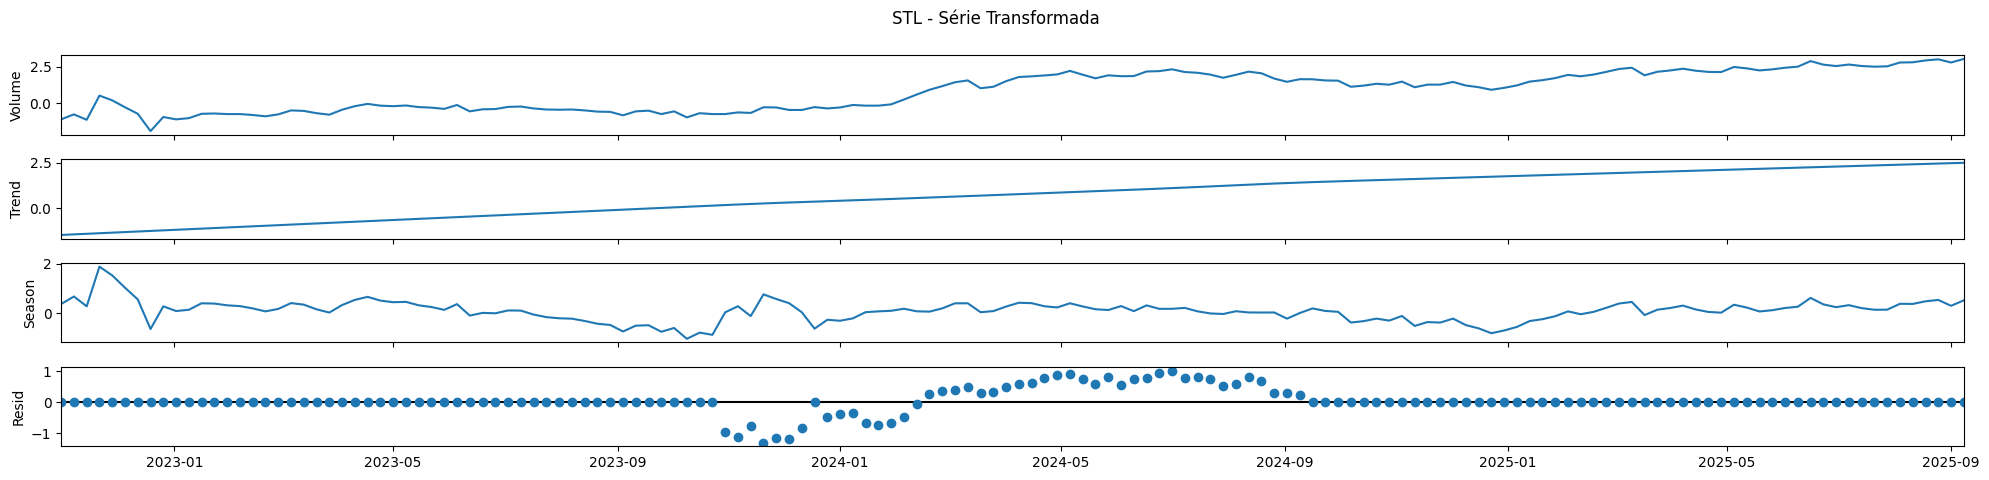

In [15]:
fig = stl_orig.plot()
fig.set_size_inches(20, 5)

plt.suptitle("STL - Série Original", y=0.95)
plt.tight_layout()

axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Volume")

plt.show()

fig = stl_bc.plot()
fig.set_size_inches(20, 5)
plt.suptitle("STL - Série Transformada", y=0.95)
plt.tight_layout()
axes = fig.get_axes()
axes[0].set_title("")
axes[0].set_ylabel("Volume")
plt.show()


- A **tendência** mostra crescimento praticamente linear ao longo dos anos, o que indica expansão contínua do volume. 

- O componente **sazonal** exibe picos e vales anuais bem definidos, confirmando sazonalidade relevante. 

- Os **resíduos** apresentam-se predominantemente aleatórios, sem estrutura aparente.


In [16]:
# Séries ajustadas sazonalmente (removendo a componente sazonal)
prison["volume_sa"] = (series_orig - stl_orig.seasonal).reindex(prison.index)
prison["volume_bc_sa"] = (series_bc - stl_bc.seasonal).reindex(prison.index)
prison

,volume,volume_bc,volume_sa,volume_bc_sa
week,,,,
2022-10-31,0.33,-1.078718,-1.372300,-1.449177
2022-11-07,0.47,-0.741054,-1.308687,-1.417611
2022-11-14,0.32,-1.107820,-1.245073,-1.386045
2022-11-21,1.69,0.531620,-1.181460,-1.354480
2022-11-28,1.23,0.208081,-1.117846,-1.322916
...,...,...,...,...
2025-08-11,13.60,2.786634,8.940453,2.412550
2025-08-18,15.20,2.913590,9.017225,2.432937
2025-08-25,16.24,2.989465,9.093997,2.453323


### Comparação de Séries

In [17]:
def train_baselines_and_metrics(y_series, h=52, sp=52):
    """
    Treina baselines e calcula métricas para qualquer série temporal.

    """
    # Divide em treino e teste
    y_tr, y_te = y_series.iloc[:-h], y_series.iloc[-h:]
    fh = ForecastingHorizon(np.arange(1, h + 1), is_relative=True)
    
    def fit_pred(strategy, sp=1):
        f = NaiveForecaster(strategy=strategy, sp=sp)
        f.fit(y_tr)
        return f.predict(fh)
    
    # Treina todos os baselines
    preds = {
        "mean":  fit_pred("mean", sp=1),
        "naive": fit_pred("last", sp=1),
        "snaive": fit_pred("last", sp=sp),   # sazonal
        "drift": fit_pred("drift", sp=1),
    }
    
    # Calcula métricas
    mase_metric = MeanAbsoluteScaledError(sp=sp)
    
    rows = []
    for name, yhat in preds.items():
        rows.append({
            "model": name,
            "MAE":  mean_absolute_error(y_te, yhat),
            "RMSE": mean_squared_error(y_te, yhat, square_root=True),
            "MAPE_%": mean_absolute_percentage_error(y_te, yhat) * 100,
            "MASE": mase_metric(y_te, yhat, y_train=y_tr),
        })
    
    return pd.DataFrame(rows).sort_values("RMSE").round(3), preds, y_tr, y_te

In [18]:
# Aplica a função anterior na série transformada
y_bc = prison["volume_bc"]
y_bc = y_bc.asfreq(pd.infer_freq(y_bc.index) or "W")
metrics_bc, preds_bc, y_tr_bc, y_te_bc = train_baselines_and_metrics(y_bc, h=52, sp=52)

In [19]:
# Comparação lado a lado
print("=== MÉTRICAS - SÉRIE ORIGINAL ===")
print(metrics)
print("\n=== MÉTRICAS - SÉRIE BOX-COX ===")
print(metrics_bc)

=== MÉTRICAS - SÉRIE ORIGINAL ===
    model    MAE   RMSE  MAPE_%   MASE
3   drift  2.894  3.671  39.182  0.836
2  snaive  4.083  4.621  59.579  1.180
1   naive  3.763  4.857  44.402  1.088
0    mean  5.485  6.748  61.472  1.585

=== MÉTRICAS - SÉRIE BOX-COX ===
    model    MAE   RMSE  MAPE_%   MASE
3   drift  0.391  0.472  26.115  0.236
1   naive  0.603  0.700  29.641  0.364
2  snaive  1.130  1.283  70.674  0.681
0    mean  1.784  1.883  87.965  1.076


## Resíduos

In [20]:
residuos = {name: y_te - yhat for name, yhat in preds.items()}
residuos_bc = {name: y_te_bc - yhat for name, yhat in preds_bc.items()}

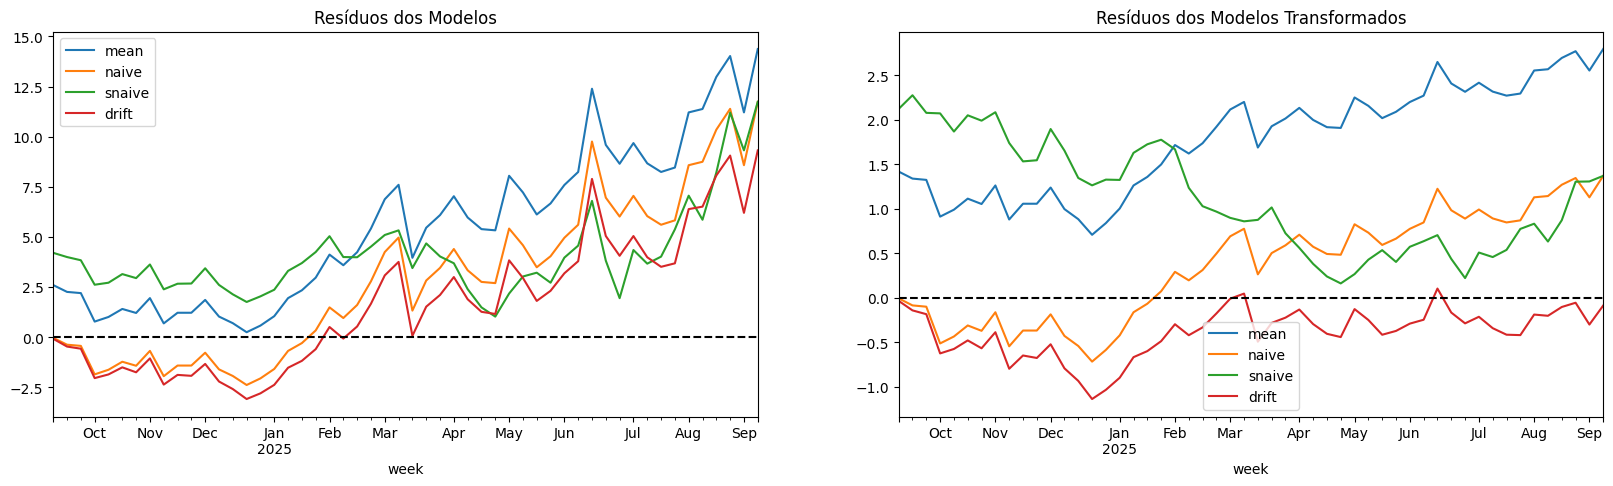

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for name, res in residuos.items():
    res.plot(ax=ax[0], label=name)

for name, res in residuos_bc.items():
    res.plot(ax=ax[1], label=name)

ax[0].axhline(0, color="black", linestyle="--")
ax[0].set_title("Resíduos dos Modelos")
ax[0].legend()

ax[1].axhline(0, color="black", linestyle="--")
ax[1].set_title("Resíduos dos Modelos Transformados")
ax[1].legend()

plt.show()

Após a transformação, os resíduos ficam mais próximos de zero e com menor variabilidade — isso ocorre em todos os modelos.


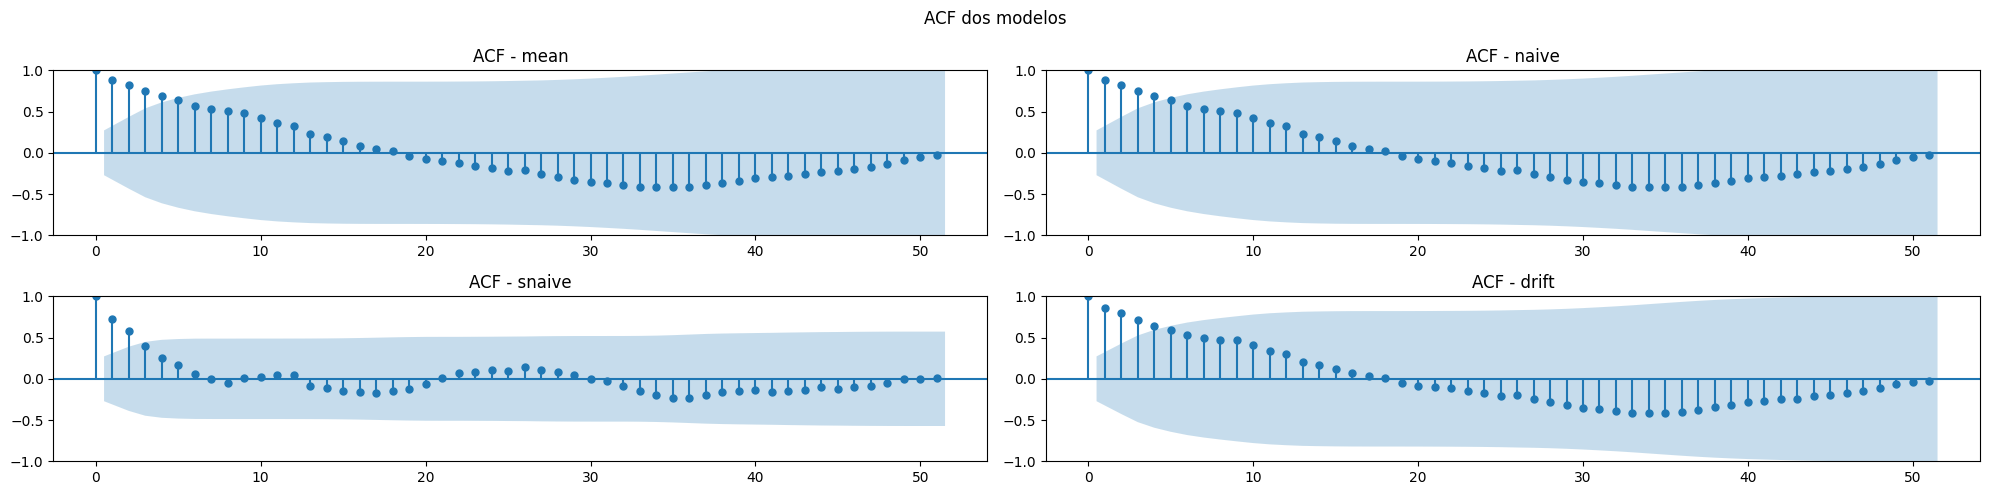

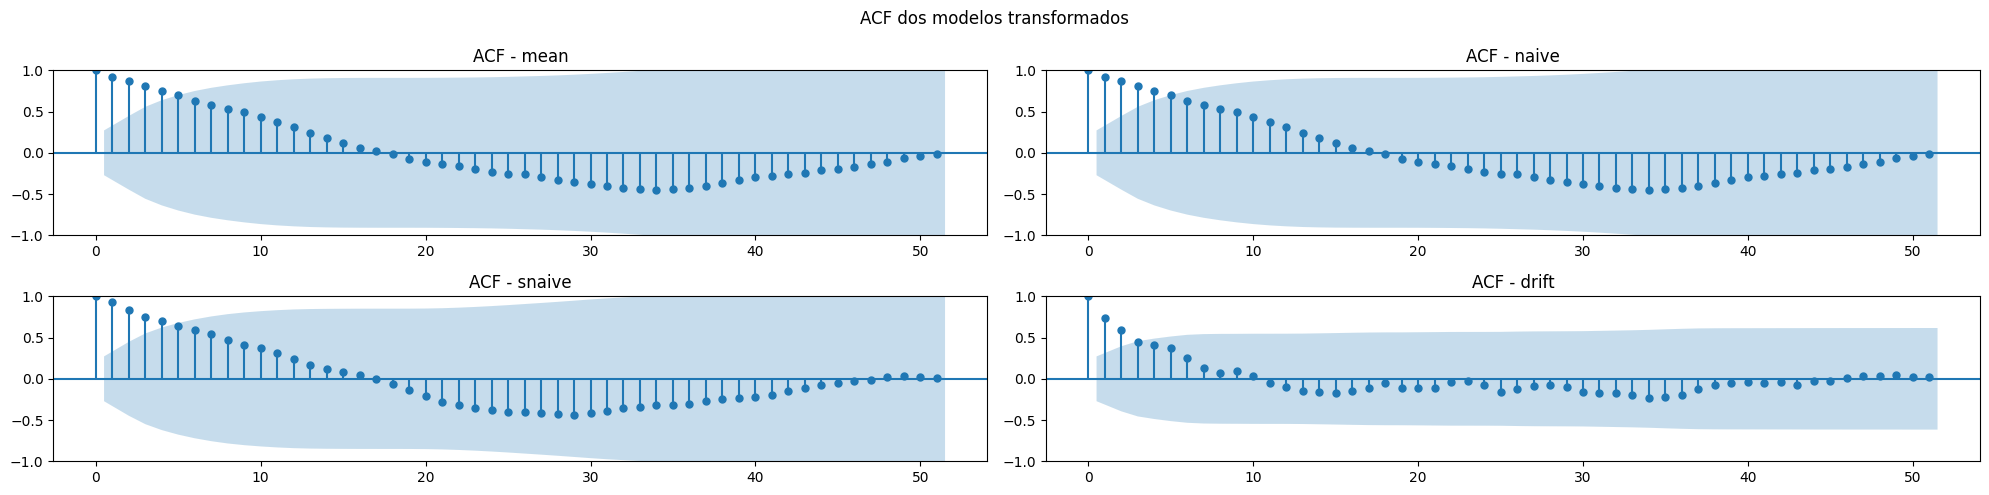

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos")

plt.tight_layout()

plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    plot_acf(res, lags=h-1, ax=ax)
    ax.set_title(f"ACF - {name}")

plt.suptitle("ACF dos modelos transformados")

plt.tight_layout()

plt.show()

Comparando o ACF entre os modelos com transformação, o Drift apresenta o melhor desempenho.

In [23]:
print("Ljung-Box p-value dos modelos")
for name, res in residuos.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

print("\n")
print("Ljung-Box p-value dos modelos transformados")
for name, res in residuos_bc.items():
    lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
    print(f"{name}: {lb_test["lb_pvalue"].values[0]}")

Ljung-Box p-value dos modelos
mean: 2.697368535557789e-47
naive: 2.6973685355576355e-47
snaive: 1.3249069015631552e-09
drift: 3.360549175219701e-42


Ljung-Box p-value dos modelos transformados
mean: 3.2507163516597504e-54
naive: 3.250716351659843e-54
snaive: 4.2938448288409615e-47
drift: 2.5156410938116654e-14


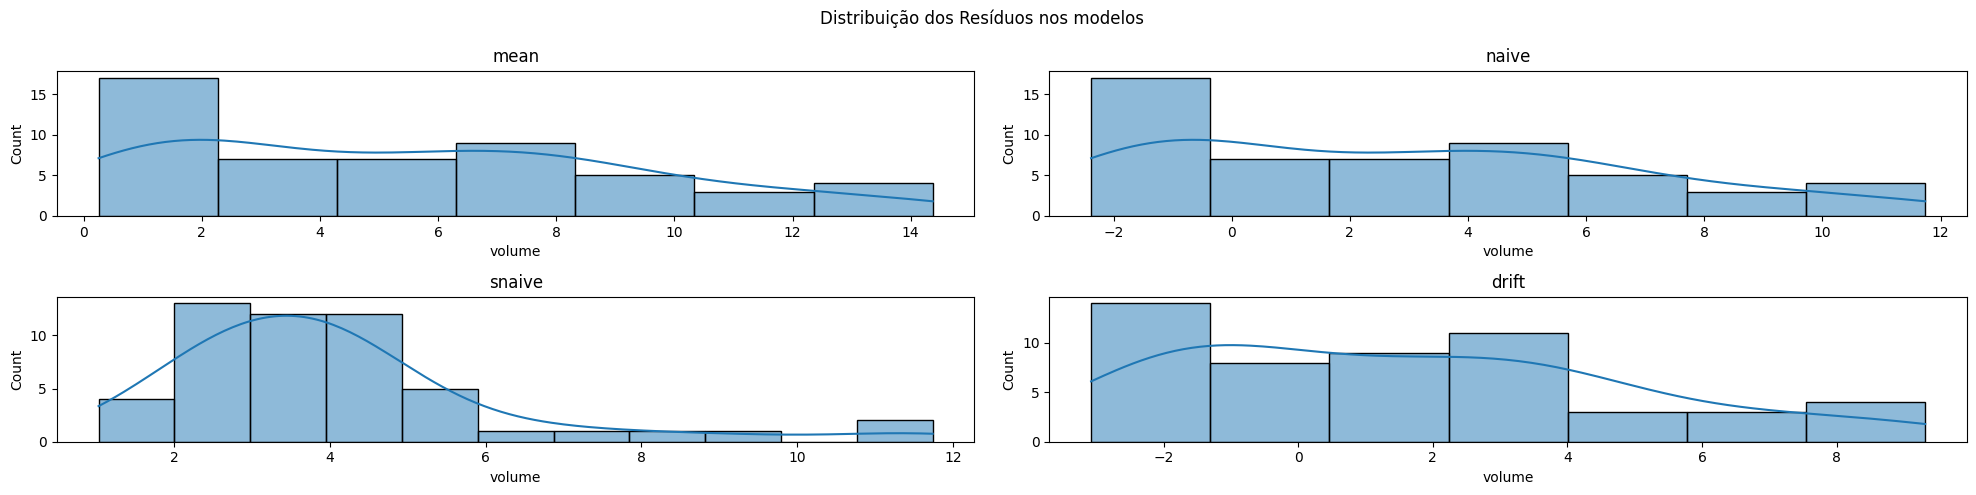

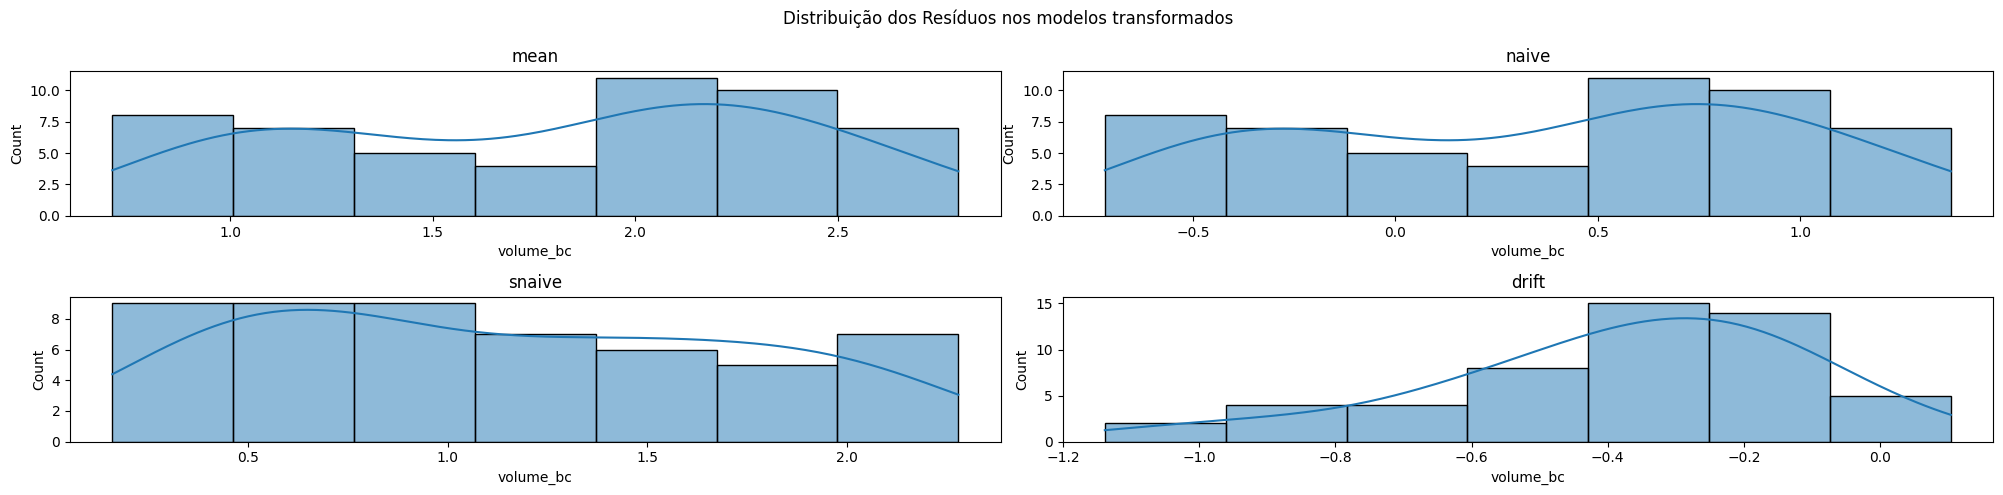

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)

plt.suptitle("Distribuição dos Resíduos nos modelos")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(20, 5))

for ax, (name, res) in zip(axes.flatten(), residuos_bc.items()):
    sns.histplot(res, kde=True, ax=ax)
    ax.set_title(name)
    
plt.suptitle("Distribuição dos Resíduos nos modelos transformados")
plt.tight_layout()
plt.show()

Para os modelos com transformação, os resíduos do Drift são os mais próximos de uma distribuição normal centrada em 0.


## Modelo de Regressão

In [25]:
prison = prison.reset_index()

Aplica-se validação cruzada temporal (5 folds), respeitando a ordem cronológica para evitar vazamento de informação


In [26]:
# CV temporal
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def cv_score_for_subset(subset, y, metric, *args):
    X_sub = subset.values
    scores = []
    for train_index, val_index in tscv.split(X_sub):
        X_tr, X_val = X_sub[train_index], X_sub[val_index]
        y_tr, y_val = y.values[train_index], y.values[val_index]

        model = LinearRegression()
        model.fit(X_tr, y_tr)
        
        y_pred = model.predict(X_val)

        if args is not None:
            scores.append(metric(y_val, y_pred, square_root=args))
        else:
            scores.append(metric(y_val, y_pred))

    return np.mean(scores), np.std(scores)


Regressão de única covariavel

In [27]:
prison["week_num"] = prison["week"].map(pd.Timestamp.toordinal)

X = prison[["week_num"]]
y = prison["volume_bc"]

h = 52

X_train, X_test = X.iloc[:-h], X.iloc[-h:]
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

# Adiciona intercepto
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

model_simple = sm.OLS(y_train, X_train).fit()

y_pred = model_simple.predict(X_test)

mae_simple = cv_score_for_subset(X, y, mean_absolute_error)
rmse_simple = cv_score_for_subset(X, y, mean_squared_error, False)

residuos_simple = y_test - y_pred

print("mean MAE: ", mae_simple[0], ", std MAE: ", mae_simple[1])
print("meam RMSE: ", rmse_simple[0], ", std RMSE: ", rmse_simple[1])

mean MAE:  0.6028689933449952 , std MAE:  0.44030772405134583
meam RMSE:  0.688159223933414 , std RMSE:  0.4463511855574647


Regressão com covariaveis derivadas de `week` e `volume`

Adicionam-se variáveis de calendário (ano, mês e dia da semana), lags (1, 2 e 52) e médias móveis (4 e 12 períodos) para capturar sazonalidade, dependência temporal e tendência local de forma mais rica.


In [28]:
y = prison.sort_values("week").set_index("week")["volume_bc"]
y = y.asfreq(pd.infer_freq(y.index) or "W")
df = y.to_frame(name="volume").reset_index()

# Extrai features temporais
df["year"] = df["week"].dt.year
df["month"] = df["week"].dt.month
df["weekofyear"] = df["week"].dt.isocalendar().week.astype(int)

# Criar defasagens (lags)
df["lag1"] = df["volume"].shift(1)
df["lag2"] = df["volume"].shift(2)
df["lag52"] = df["volume"].shift(52)  # captura sazonalidade anual

# Cria médias móveis
df["rolling_mean_4"] = df["volume"].shift(1).rolling(4).mean()
df["rolling_mean_12"] = df["volume"].shift(1).rolling(12).mean()

df = df.dropna()

In [29]:
X = df[["year", "month", "weekofyear",
        "lag1", "lag2", "lag52", "rolling_mean_4", "rolling_mean_12"]]
y = df["volume"]

h = 52

X_train, X_test = X.iloc[:-h], X.iloc[-h:]
y_train, y_test = y.iloc[:-h], y.iloc[-h:]

# Adiciona intercepto
X_train = sm.add_constant(X_train)
X_test["const"] = np.ones(X_test.shape[0])
X_test = X_test[X_train.columns]

cols = X.columns.tolist()

C:\Users\casti\AppData\Local\Temp\ipykernel_15424\3723365723.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["const"] = np.ones(X_test.shape[0])


In [30]:
model_complete = sm.OLS(y_train, X_train).fit()

y_pred = model_complete.predict(X_test)

mae_complete = cv_score_for_subset(X[cols], y, mean_absolute_error)
rmse_complete = cv_score_for_subset(X[cols], y, mean_squared_error, False)

residuos_complete = y_test - y_pred

print("mean MAE: ", mae_complete[0], ", std MAE: ", mae_complete[1])
print("meam RMSE: ", rmse_complete[0], ", std RMSE: ", rmse_complete[1])

mean MAE:  0.7675740759911192 , std MAE:  1.0095256803105572
meam RMSE:  0.8613316888243941 , std RMSE:  1.0692171213385637


Testam-se todas as combinações das features derivadas usando a lógica de leave-one-out temporal. O ranking considerou a média e o desvio padrão do MAE e do RMSE em cada fold. As features selecionadas foram: `year`, `lag1` e `lag2`.


In [31]:
# busca exaustiva (todas as combinações)
results = []
for k in range(1, len(cols)):
    for subset in itertools.combinations(cols, k):
        mean_MAE_score, std_MAE_score = cv_score_for_subset(X[list(subset)], y, mean_absolute_error)
        mean_RMSE_score, std_RMSE_score = cv_score_for_subset(X[list(subset)], y, mean_squared_error, False)
        results.append({
            "subset": subset,
            "k": k,
            "mean MAE": mean_MAE_score,
            "std MAE": std_MAE_score,
            "mean RMSE": mean_RMSE_score,
            "std RMSE": std_RMSE_score
        })

res_df = pd.DataFrame(results).sort_values("mean MAE")
res_df


,subset,k,mean MAE,std MAE,mean RMSE,std RMSE
47,"(year, lag1, lag2)",3,0.163547,0.034333,0.211895,0.053372
72,"(weekofyear, lag1, lag2)",3,0.163957,0.036534,0.212828,0.055791
10,"(year, lag1)",2,0.167333,0.050187,0.216942,0.068963
62,"(month, lag1, lag2)",3,0.167357,0.034870,0.214918,0.054971
21,"(weekofyear, lag1)",2,0.169098,0.049377,0.217004,0.068843
...,...,...,...,...,...,...
46,"(year, weekofyear, rolling_mean_12)",3,1.011928,0.839503,1.154329,0.951369
96,"(year, month, weekofyear, rolling_mean_12)",4,1.062818,0.879136,1.214003,0.990461
1,"(month,)",1,1.132689,0.474980,1.161169,0.475143
15,"(month, weekofyear)",2,1.138966,0.478565,1.167144,0.480375


In [32]:
best_features = list(res_df.iloc[0]["subset"])

final_model = sm.OLS(y_train, X_train[best_features]).fit()

pred_res = final_model.get_prediction(X_test[best_features])
summary = pred_res.summary_frame()

pred_means = summary["mean"].values
pred_lower = summary["mean_ci_lower"].values
pred_upper = summary["mean_ci_upper"].values
pred_index = X_test.index.tolist()

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

residuos_best = y_test - y_pred

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(final_model.summary())

MAE:  0.15441879382273171
RMSE:  0.19422264333295294
                                 OLS Regression Results                                
Dep. Variable:                 volume   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              822.8
Date:                Thu, 06 Nov 2025   Prob (F-statistic):                    5.55e-38
Time:                        10:10:51   Log-Likelihood:                          10.267
No. Observations:                  46   AIC:                                     -14.53
Df Residuals:                      43   BIC:                                     -9.049
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025 

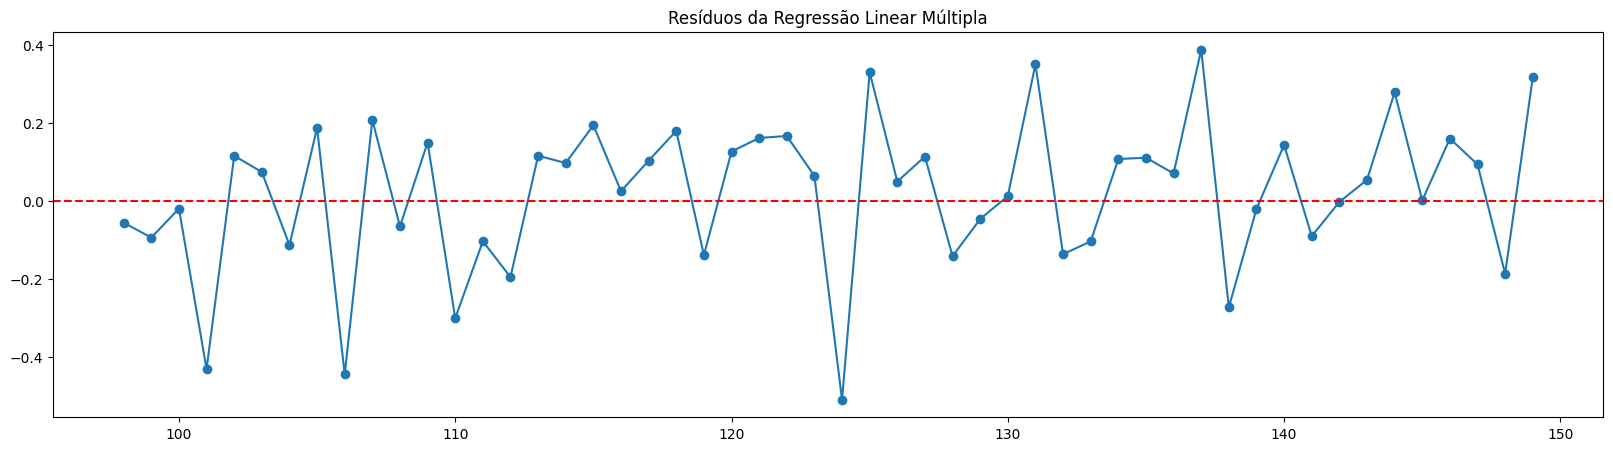

In [33]:
plt.figure(figsize=(20,5))

plt.plot(residuos_best, marker="o")

plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos da Regressão Linear Múltipla")
plt.show()

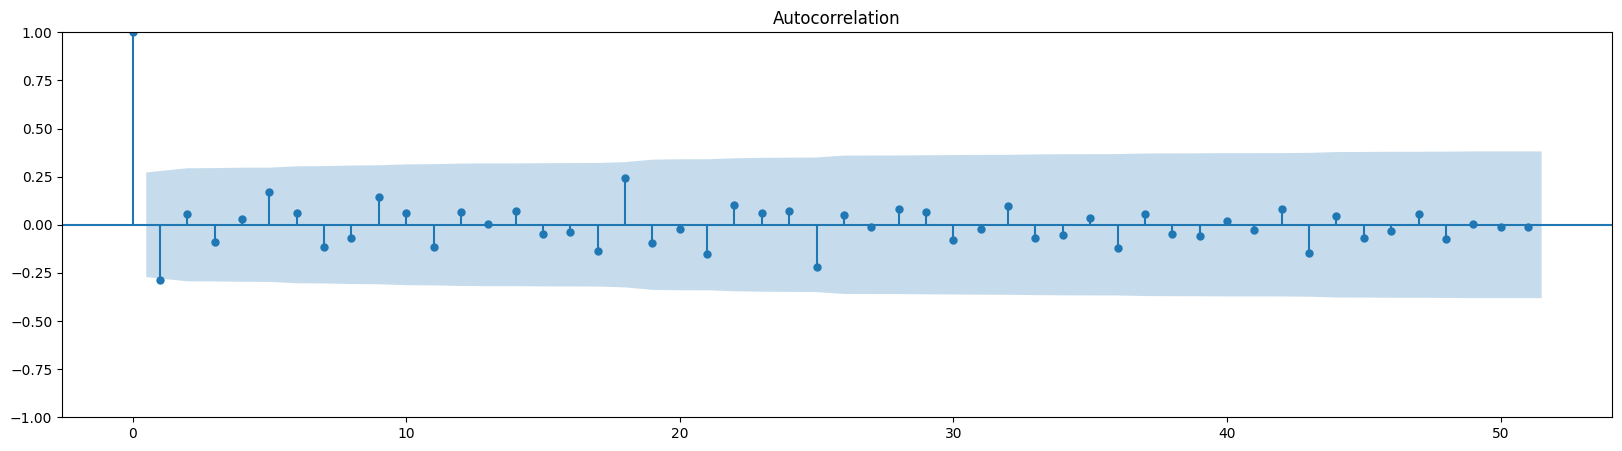

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_acf(residuos_best, lags=residuos_best.shape[0] - 1, ax=ax)

plt.show()

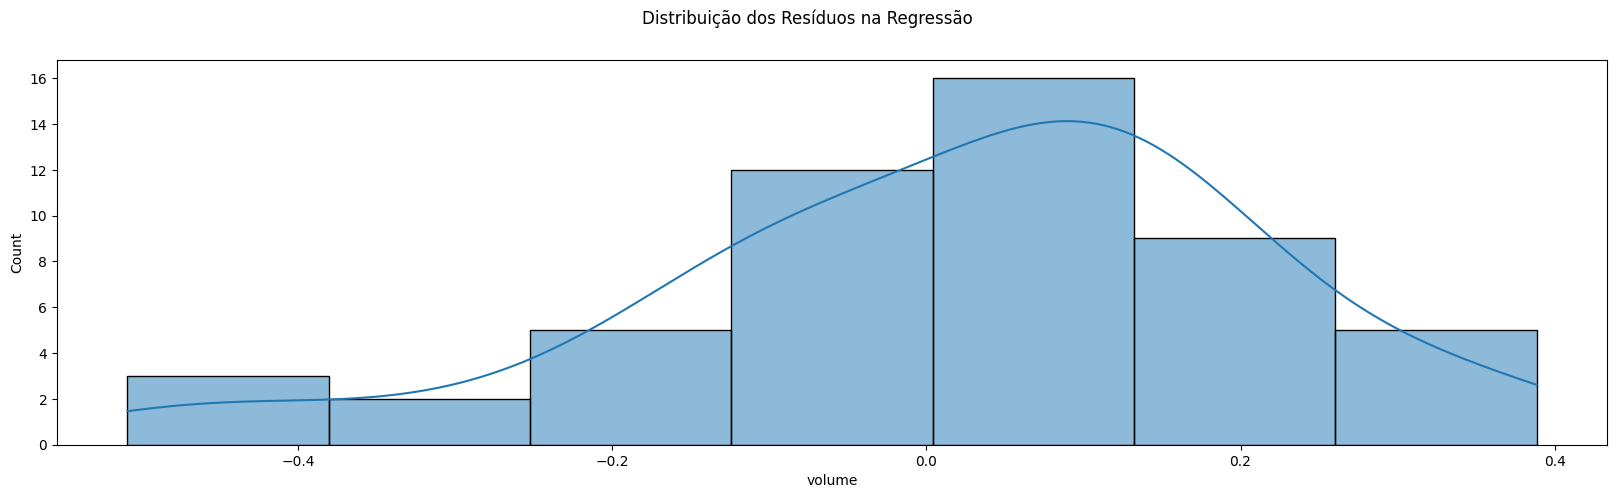

In [35]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.histplot(residuos_best, kde=True, ax=ax)

plt.suptitle("Distribuição dos Resíduos na Regressão")

plt.show()

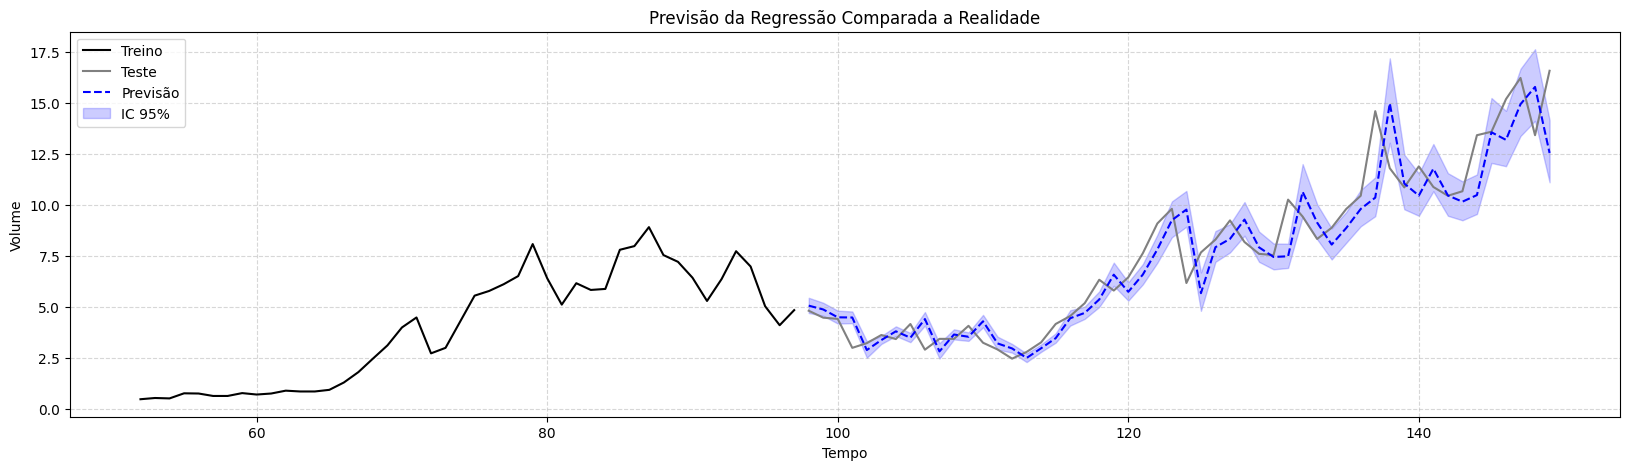

In [36]:
# Cria um grid 2x2 de subplots
plt.figure(figsize=(20, 5))

plt.plot(y_train.index, inv_boxcox(y_train, lmbda), color="black", label="Treino")
plt.plot(y_test.index, inv_boxcox(y_test, lmbda), color="gray", label="Teste")

plt.plot(y_test.index, inv_boxcox(y_pred, lmbda), color="blue", linestyle="--", label="Previsão")
    
# intervalo de confiança
plt.fill_between(y_test.index, inv_boxcox(pred_lower.values, lmbda), inv_boxcox(pred_upper.values, lmbda),
                 color="blue", alpha=0.2, label="IC 95%")
    
plt.title("Previsão da Regressão Comparada a Realidade")
plt.xlabel("Tempo")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.show()

In [37]:
X.iloc[-4:]

,year,month,weekofyear,lag1,lag2,lag52,rolling_mean_4,rolling_mean_12
146,2025,8,34,2.786634,2.772321,2.041383,2.640469,2.581274
147,2025,8,35,2.913590,2.786634,1.684084,2.746426,2.631759
148,2025,9,36,2.989465,2.913590,1.464169,2.865502,2.679398
149,2025,9,37,2.772321,2.989465,1.642485,2.865502,2.702945


### Novo Experimento

In [44]:
pred_means = list()
pred_lower = list()
pred_upper = list()
pred_index = list()

X_loop = X[best_features].copy()

for h in range(4, 53, 4):
    n_forecast = 56 - h
    if n_forecast > 4:
        X_train, X_test = X_loop.iloc[:-n_forecast].copy(), X_loop.iloc[-n_forecast:-n_forecast + 4].copy()
        y_train, y_test = y.iloc[:-n_forecast].copy(), y.iloc[-n_forecast: -n_forecast + 4].copy()
    else:
        X_train, X_test = X_loop.iloc[:-4].copy(), X_loop.iloc[-n_forecast:].copy()
        y_train, y_test = y.iloc[:-4].copy(), y.iloc[-n_forecast:].copy()

    X_train = sm.add_constant(X_train)
    X_test["const"] = np.ones(X_test.shape[0])
    X_test = X_test[X_train.columns]
    model = sm.OLS(y_train, X_train).fit()

    pred_res = model.get_prediction(X_test)
    summary = pred_res.summary_frame()
    
    pred_means.extend(summary["mean"].values)
    pred_lower.extend(summary["mean_ci_lower"].values)
    pred_upper.extend(summary["mean_ci_upper"].values)
    pred_index.extend(X_test.index.tolist())

# converte para arrays / séries alinhadas por índice
y_pred = pd.Series(pred_means, index=pred_index).sort_index().values
pred_lower = pd.Series(pred_lower, index=pred_index).sort_index()
pred_upper = pd.Series(pred_upper, index=pred_index).sort_index()

In [45]:
y_test = y.iloc[-52:]

residuos = y_pred - y_test

print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred, square_root=True))
print(model.summary())

MAE:  0.13825325161024407
RMSE:  0.18302710991515328
                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     733.8
Date:                qui, 06 nov 2025   Prob (F-statistic):           4.07e-63
Time:                        10:13:48   Log-Likelihood:                 26.443
No. Observations:                  94   AIC:                            -44.89
Df Residuals:                      90   BIC:                            -34.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

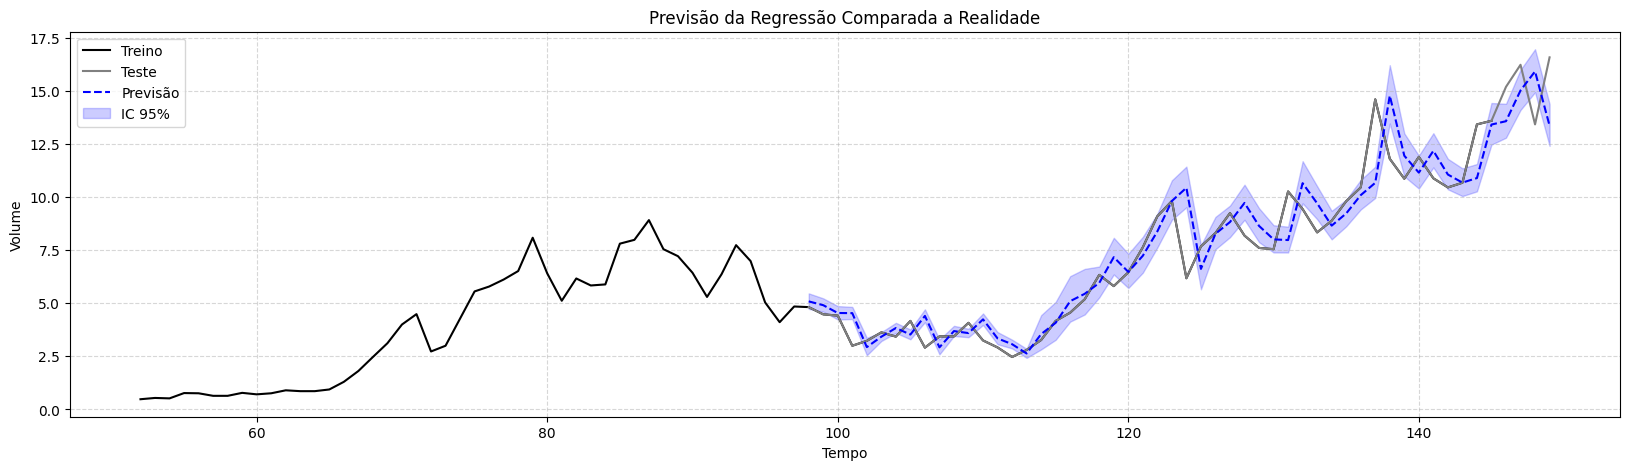

In [46]:
plt.figure(figsize=(20, 5))

plt.plot(y_train.index, inv_boxcox(y_train, lmbda), color="black", label="Treino")
plt.plot(y_test.index, inv_boxcox(y_test, lmbda), color="gray", label="Teste")

plt.plot(y_test.index, inv_boxcox(y_pred, lmbda), color="blue", linestyle="--", label="Previsão")

# intervalo de confiança
plt.fill_between(y_test.index, inv_boxcox(pred_lower.values, lmbda), inv_boxcox(pred_upper.values, lmbda),
                 color="blue", alpha=0.2, label="IC 95%")
    
plt.title("Previsão da Regressão Comparada a Realidade")
plt.xlabel("Tempo")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.show()

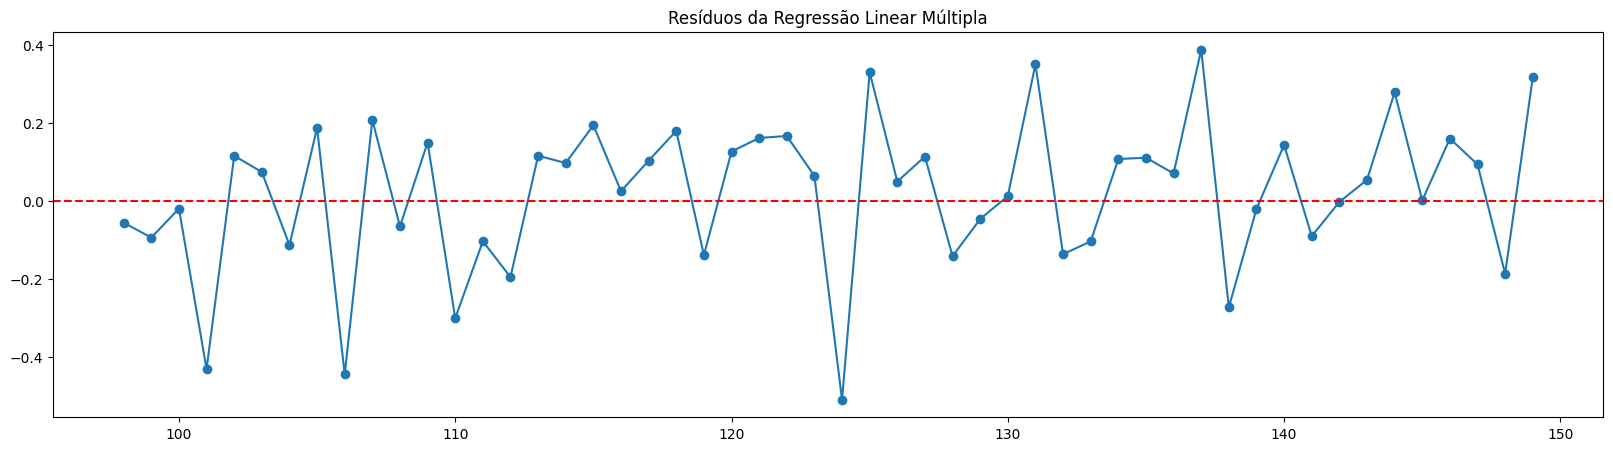

In [47]:
plt.figure(figsize=(20,5))

plt.plot(residuos_best, marker="o")

plt.axhline(0, color="red", linestyle="--")
plt.title("Resíduos da Regressão Linear Múltipla")
plt.show()

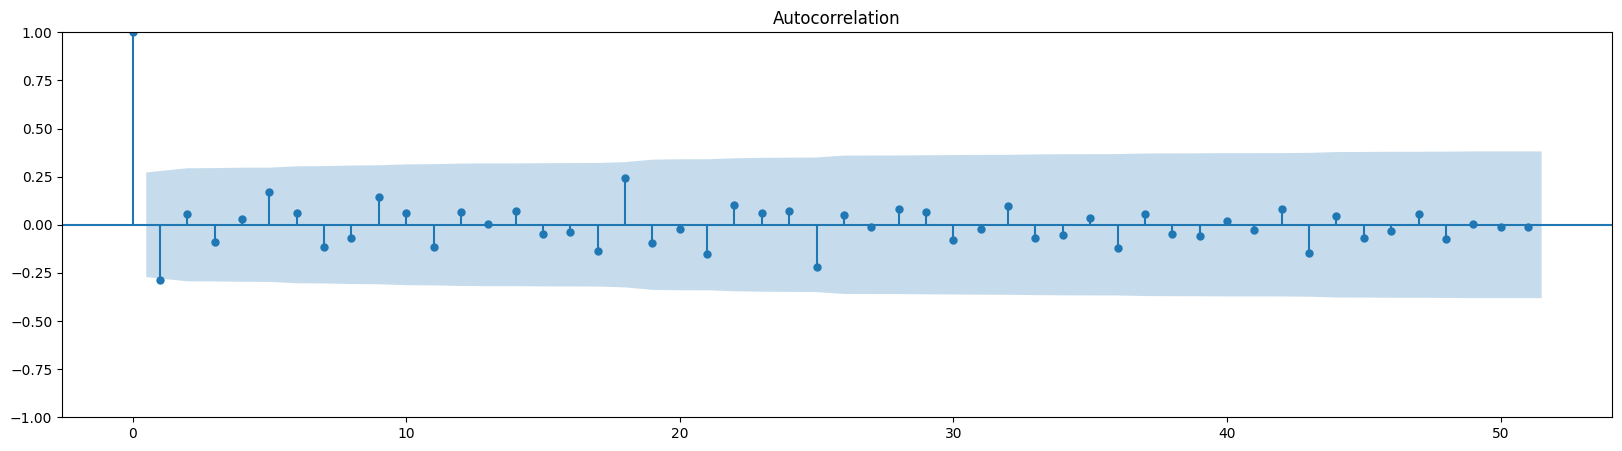

In [48]:
fig, ax = plt.subplots(figsize=(20, 5))

plot_acf(residuos_best, lags=residuos_best.shape[0] - 1, ax=ax)

plt.show()

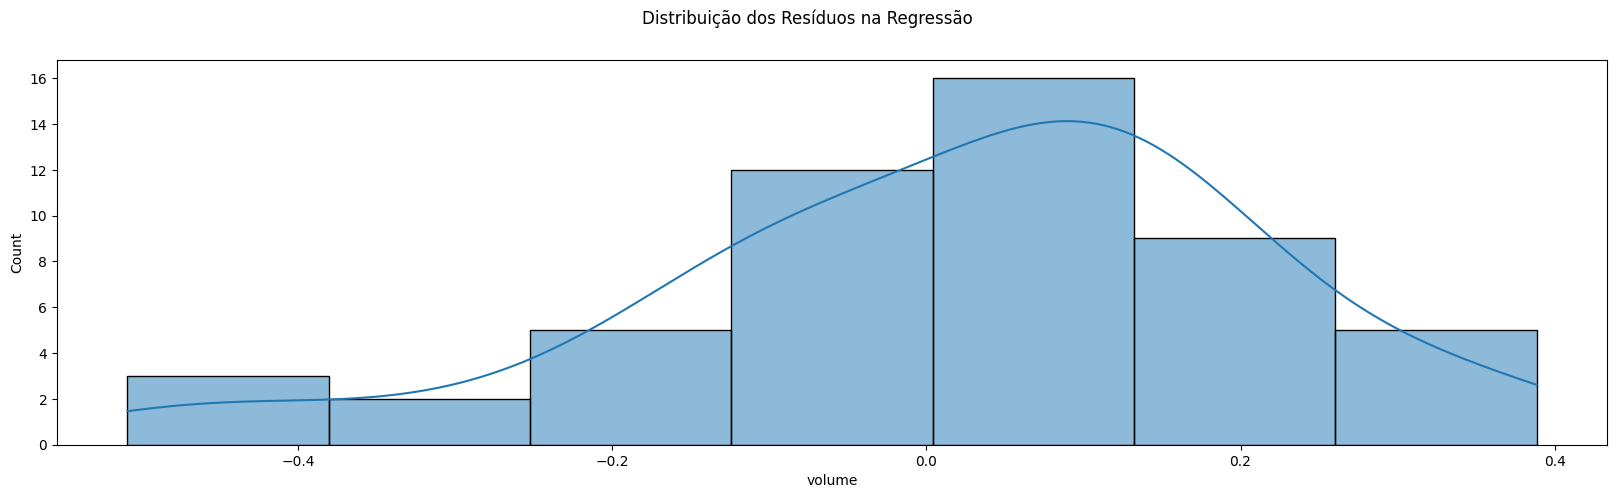

In [49]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.histplot(residuos_best, kde=True, ax=ax)

plt.suptitle("Distribuição dos Resíduos na Regressão")

plt.show()